In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3,MobileNetV2, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [5]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:11<00:00, 17.19it/s]


In [6]:
print(len(lrv_test))

200


In [7]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
virus_train_label = np.full(len(virus_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
healthy_train_label = np.full(len(healthy_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
virus_test_label = np.full(len(virus_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
healthy_test_label = np.full(len(healthy_test),6)

In [8]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, virus_train, insect_train, lrv_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, virus_train_label, insect_train_label, lrv_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, virus_test, insect_test, lrv_test,  healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, virus_test_label, insect_test_label, lrv_test_label, healthy_test_label), axis = 0)

In [9]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [10]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [12]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [13]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

NASNetMobile     = NASNetMobile(include_top=False, input_shape=input_shape)(inputs)

19993432/19993432 [==============================] - 0s 0us/step


In [14]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(NASNetMobile)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (  (None, 1056)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate_4 (Concatenate  (None, 1056)              0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1056)              0         
                                                                 
 batch_normalization (Batch  (None, 1056)              4224  

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/NASNetMobile(7_classes)_old.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
137/136 [==============================] - ETA: 0s - loss: 1.4316 - accuracy: 0.4746

136/136 [==============================] - 119s 608ms/step - loss: 1.4316 - accuracy: 0.4746 - val_loss: 2.1552 - val_accuracy: 0.1180 - lr: 1.0000e-04
Epoch 2/50
137/136 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.7588

136/136 [==============================] - 76s 555ms/step - loss: 0.6447 - accuracy: 0.7588 - val_loss: 2.1316 - val_accuracy: 0.1995 - lr: 1.0000e-04
Epoch 3/50
137/136 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.8231

136/136 [==============================] - 79s 580ms/step - loss: 0.4752 - accuracy: 0.8231 - val_loss: 2.3744 - val_accuracy: 0.2845 - lr: 1.0000e-04
Epoch 4/50
137/136 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.8494

136/136 [==============================] - 83s 606ms/step - loss: 0.4043 - accuracy: 0.8494 - val_loss: 2.2567 - val_accuracy: 0.3394 - lr: 1.0000e-04
Epoch 5/50
137/136 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8606

136/136 [==============================] - 81s 596ms/step - loss: 0.3607 - accuracy: 0.8606 - val_loss: 1.6862 - val_accuracy: 0.4437 - lr: 1.0000e-04
Epoch 6/50
137/136 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8746

136/136 [==============================] - 83s 606ms/step - loss: 0.3294 - accuracy: 0.8746 - val_loss: 1.2233 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 7/50
137/136 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.8920

136/136 [==============================] - 82s 600ms/step - loss: 0.2730 - accuracy: 0.8920 - val_loss: 0.8281 - val_accuracy: 0.6761 - lr: 1.0000e-04
Epoch 8/50
137/136 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.8913

136/136 [==============================] - 81s 594ms/step - loss: 0.2798 - accuracy: 0.8913 - val_loss: 0.6976 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 9/50
137/136 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.8952

136/136 [==============================] - 78s 572ms/step - loss: 0.2563 - accuracy: 0.8952 - val_loss: 0.5102 - val_accuracy: 0.7951 - lr: 1.0000e-04
Epoch 10/50
137/136 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.9050

136/136 [==============================] - 79s 577ms/step - loss: 0.2508 - accuracy: 0.9050 - val_loss: 0.4162 - val_accuracy: 0.8417 - lr: 1.0000e-04
Epoch 11/50
137/136 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.9009

136/136 [==============================] - 78s 568ms/step - loss: 0.2527 - accuracy: 0.9009 - val_loss: 0.4561 - val_accuracy: 0.8188 - lr: 1.0000e-04
Epoch 12/50
137/136 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9064

136/136 [==============================] - 78s 571ms/step - loss: 0.2413 - accuracy: 0.9064 - val_loss: 0.4008 - val_accuracy: 0.8280 - lr: 1.0000e-04
Epoch 13/50
137/136 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9078

136/136 [==============================] - 78s 572ms/step - loss: 0.2281 - accuracy: 0.9078 - val_loss: 0.2687 - val_accuracy: 0.8957 - lr: 1.0000e-04
Epoch 14/50
137/136 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9140

136/136 [==============================] - 78s 570ms/step - loss: 0.2158 - accuracy: 0.9140 - val_loss: 0.2951 - val_accuracy: 0.8756 - lr: 1.0000e-04
Epoch 15/50
137/136 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.9174

136/136 [==============================] - 78s 568ms/step - loss: 0.2193 - accuracy: 0.9174 - val_loss: 0.2996 - val_accuracy: 0.8774 - lr: 1.0000e-04
Epoch 16/50
137/136 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9153

136/136 [==============================] - 78s 570ms/step - loss: 0.2092 - accuracy: 0.9153 - val_loss: 0.1815 - val_accuracy: 0.9323 - lr: 1.0000e-04
Epoch 17/50
137/136 [==============================] - ETA: 0s - loss: 0.1933 - accuracy: 0.9224

136/136 [==============================] - 78s 568ms/step - loss: 0.1933 - accuracy: 0.9224 - val_loss: 0.1716 - val_accuracy: 0.9296 - lr: 1.0000e-04
Epoch 18/50
137/136 [==============================] - ETA: 0s - loss: 0.1972 - accuracy: 0.9238

136/136 [==============================] - 77s 562ms/step - loss: 0.1972 - accuracy: 0.9238 - val_loss: 0.1271 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 19/50
137/136 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9300

136/136 [==============================] - 79s 575ms/step - loss: 0.1793 - accuracy: 0.9300 - val_loss: 0.1128 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 20/50
137/136 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9249

136/136 [==============================] - 78s 571ms/step - loss: 0.1963 - accuracy: 0.9249 - val_loss: 0.1346 - val_accuracy: 0.9543 - lr: 1.0000e-04
Epoch 21/50
137/136 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9268

136/136 [==============================] - 78s 569ms/step - loss: 0.1813 - accuracy: 0.9268 - val_loss: 0.0761 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 22/50
137/136 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9316

136/136 [==============================] - 79s 577ms/step - loss: 0.1720 - accuracy: 0.9316 - val_loss: 0.1045 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 23/50
137/136 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9291

136/136 [==============================] - 77s 567ms/step - loss: 0.1851 - accuracy: 0.9291 - val_loss: 0.0810 - val_accuracy: 0.9716 - lr: 1.0000e-04
Epoch 24/50
137/136 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9332

136/136 [==============================] - 77s 566ms/step - loss: 0.1596 - accuracy: 0.9332 - val_loss: 0.0755 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 25/50
137/136 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.9307

136/136 [==============================] - 79s 575ms/step - loss: 0.1661 - accuracy: 0.9307 - val_loss: 0.0772 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 26/50
137/136 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9341

136/136 [==============================] - 78s 568ms/step - loss: 0.1769 - accuracy: 0.9341 - val_loss: 0.0663 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 27/50
137/136 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9398

136/136 [==============================] - 79s 577ms/step - loss: 0.1489 - accuracy: 0.9398 - val_loss: 0.0593 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 28/50
137/136 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9348

136/136 [==============================] - 78s 571ms/step - loss: 0.1634 - accuracy: 0.9348 - val_loss: 0.0619 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 29/50
137/136 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9341

136/136 [==============================] - 79s 575ms/step - loss: 0.1582 - accuracy: 0.9341 - val_loss: 0.0994 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 30/50
137/136 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9302

136/136 [==============================] - 77s 567ms/step - loss: 0.1717 - accuracy: 0.9302 - val_loss: 0.0762 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 31/50
137/136 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9346

136/136 [==============================] - 77s 560ms/step - loss: 0.1561 - accuracy: 0.9346 - val_loss: 0.0856 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 32/50
137/136 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9449

136/136 [==============================] - 76s 558ms/step - loss: 0.1456 - accuracy: 0.9449 - val_loss: 0.0753 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 33/50
137/136 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9444

136/136 [==============================] - 76s 551ms/step - loss: 0.1448 - accuracy: 0.9444 - val_loss: 0.0744 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 34/50
137/136 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9437

136/136 [==============================] - 79s 574ms/step - loss: 0.1440 - accuracy: 0.9437 - val_loss: 0.0834 - val_accuracy: 0.9753 - lr: 1.0000e-04
Epoch 35/50
137/136 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9389

136/136 [==============================] - 78s 571ms/step - loss: 0.1549 - accuracy: 0.9389 - val_loss: 0.0824 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 36/50
137/136 [==============================] - ETA: 0s - loss: 0.1418 - accuracy: 0.9419

136/136 [==============================] - 77s 565ms/step - loss: 0.1418 - accuracy: 0.9419 - val_loss: 0.0723 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 37/50
137/136 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9462

136/136 [==============================] - 77s 561ms/step - loss: 0.1423 - accuracy: 0.9462 - val_loss: 0.0558 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 38/50
137/136 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 0.9474

136/136 [==============================] - 76s 555ms/step - loss: 0.1404 - accuracy: 0.9474 - val_loss: 0.0472 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 39/50
137/136 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9426

136/136 [==============================] - 76s 559ms/step - loss: 0.1377 - accuracy: 0.9426 - val_loss: 0.0489 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 40/50
137/136 [==============================] - ETA: 0s - loss: 0.1340 - accuracy: 0.9439

136/136 [==============================] - 76s 559ms/step - loss: 0.1340 - accuracy: 0.9439 - val_loss: 0.0530 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 41/50
137/136 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9455

136/136 [==============================] - 76s 556ms/step - loss: 0.1357 - accuracy: 0.9455 - val_loss: 0.0470 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 42/50
137/136 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9478

136/136 [==============================] - 74s 545ms/step - loss: 0.1282 - accuracy: 0.9478 - val_loss: 0.0558 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 43/50
137/136 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9522

136/136 [==============================] - 77s 565ms/step - loss: 0.1242 - accuracy: 0.9522 - val_loss: 0.0929 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 44/50
137/136 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9485

136/136 [==============================] - 77s 562ms/step - loss: 0.1232 - accuracy: 0.9485 - val_loss: 0.0453 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 45/50
137/136 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9449

136/136 [==============================] - 77s 562ms/step - loss: 0.1377 - accuracy: 0.9449 - val_loss: 0.0473 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 46/50
137/136 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9485

136/136 [==============================] - 76s 560ms/step - loss: 0.1288 - accuracy: 0.9485 - val_loss: 0.0398 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 47/50
137/136 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9458

136/136 [==============================] - 77s 561ms/step - loss: 0.1334 - accuracy: 0.9458 - val_loss: 0.0528 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 48/50
137/136 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9522

136/136 [==============================] - 78s 567ms/step - loss: 0.1272 - accuracy: 0.9522 - val_loss: 0.0555 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 49/50
137/136 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9494

136/136 [==============================] - 78s 569ms/step - loss: 0.1250 - accuracy: 0.9494 - val_loss: 0.0316 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 50/50
137/136 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9549

136/136 [==============================] - 77s 565ms/step - loss: 0.1156 - accuracy: 0.9549 - val_loss: 0.0438 - val_accuracy: 0.9890 - lr: 1.0000e-04


47/47 [==============================] - 8s 81ms/step
Confusion matrix, without normalization
[[203   0   0   0   0   0   3]
 [  0 278   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  0   0   0 197   3   0   0]
 [  0   0   0   4 202   0   0]
 [  0   0   5   0  18 177   0]
 [  0   0   0   0   0   0 205]]


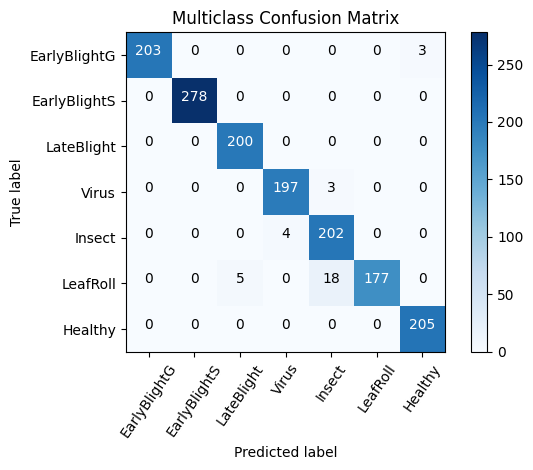

In [17]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Virus' , 'Insect','LeafRoll', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

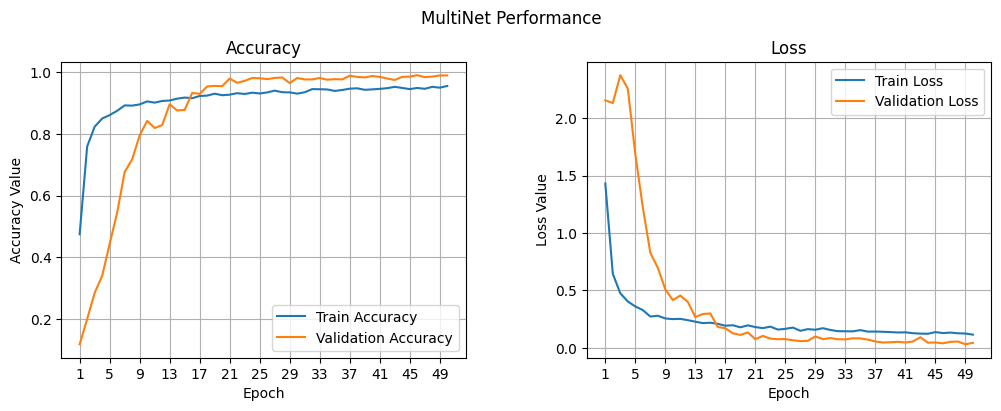

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight','Virus' , 'Insect','LeafRoll','Healthy' ]
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 3s 62ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       1.00      0.99      0.99       206
EarlyBlight Serious       1.00      1.00      1.00       278
         LateBlight       0.98      1.00      0.99       200
              Virus       0.98      0.98      0.98       200
             Insect       0.91      0.98      0.94       206
           LeafRoll       1.00      0.89      0.94       200
            Healthy       0.99      1.00      0.99       205

           accuracy                           0.98      1495
          macro avg       0.98      0.98      0.98      1495
       weighted avg       0.98      0.98      0.98      1495



In [20]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("NASNetMobile")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 3s 59ms/step
NASNetMobile
Accuracy: 0.9779264214046822
F1 Score: 0.9780379717061717
precision: 0.9794940416274313
recall: 0.9779264214046822
MSE: 0.11906354515050167
MAE: 0.03879598662207358


In [21]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

47/47 [==============================] - 3s 65ms/step


In [22]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=6)
auc=metrics.auc(fpr, tpr)
auc

0.9988372093023256

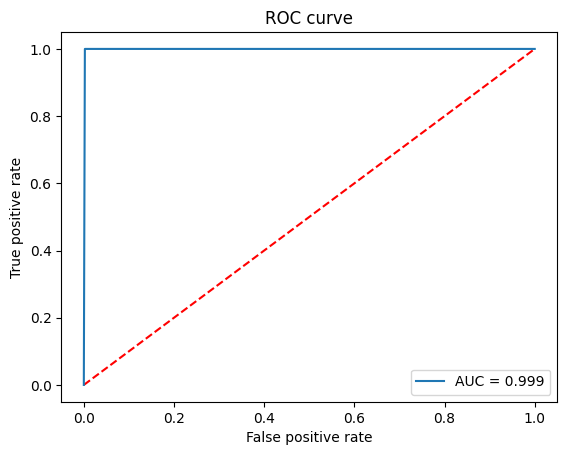

In [23]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
